<a href="https://colab.research.google.com/github/sanyagupta31/ml-projects/blob/main/hybird_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
data=pd.read_csv('/content/AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


As the dataset is based on stock market data, I’ll convert the date column to a datetime type, set it as the index, and focus on the Close price:

In [3]:
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
data=data[['Close']]

In [4]:
data.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


We will be using LSTM (Long Short-Term Memory) and Linear Regression models for this task. I chose LSTM because it effectively captures sequential dependencies and patterns in time-series data, which makes it suitable for modelling stock price movements influenced by historical trends.


Linear Regression, on the other hand, is a straightforward model that captures simple linear relationships and long-term trends in data. By combining these two models into a hybrid approach, we leverage the LSTM’s ability to model complex time-dependent patterns alongside the Linear Regression’s ability to identify and follow broader trends. This combination aims to create a more balanced and accurate prediction system.

So, let’s scale the Close price data between 0 and 1 using MinMaxScaler to ensure compatibility with the LSTM model:

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data['Close']=scaler.fit_transform(data[['Close']])

Now, let’s prepare the data for LSTM by creating sequences of a defined length (e.g., 60 days) to predict the next day’s price:

In [5]:
import numpy as np
def create_sequences(data,seq_length=60):
  X,y=[],[]
  for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X),np.array(y)
seq_length =60
X,y = create_sequences(data['Close'].values,seq_length)


Now, we will split the sequences into training and test sets (e.g., 80% training, 20% testing):

In [6]:
train_size=int(len(X)*0.8)
X_train,X_test=X[:train_size],X[train_size:]
y_train,y_test=y[:train_size],y[train_size:]

Now, we will build a sequential LSTM model with layers to capture the temporal dependencies in the data:

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now, we will compile the model using an appropriate optimizer and loss function, and fit it into the training data:

In [9]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.7213e-04
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.5730e-06
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.2908e-06
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7356e-06
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.4651e-06
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8667e-06
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5330e-06
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5758e-06
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.2861e-06
Epoch 10/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.9059e-06
Epoch 11/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.6857e-06
Epoch 12/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5550e-06
Epoch 13/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.4087e-06
Epoch 14/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5816e-0

Now, let’s train the second model. I’ll start by generating lagged features for Linear Regression (e.g., using the past 3 days as predictors):

In [10]:
data['lag_1']=data['Close'].shift(1)
data['lag_2']=data['Close'].shift(2)
data['lag_3']=data['Close'].shift(3)
data=data.dropna()

Now, we will split the data accordingly for training and testing:

In [11]:
X_lin=data[['lag_1','lag_2','lag_3']]
y_lin=data['Close']
X_train_lin,X_test_lin=X_lin[:train_size],X_lin[train_size:]
y_train_lin,y_test_lin=y_lin[:train_size],y_lin[train_size:]

Now, let’s train the linear regression model:

In [12]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()
lin_model.fit(X_train_lin,y_train_lin)

LinearRegression()

Now, here’s how to make predictions using LSTM on the test set and inverse transform the scaled predictions:

In [13]:
X_test_lstm = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
lstm_predictions=lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Here’s how to generate predictions using Linear Regression and inverse-transform them:



In [14]:
lin_predictions = lin_model.predict(X_test_lin)
lin_predictions = scaler.inverse_transform(lin_predictions.reshape(-1,1))

Let’s see how to make predictions for the next 10 days using our hybrid model. Here’s how to predict the Next 10 Days using LSTM:

In [16]:
lstm_future_predictions = []
last_sequence = X[-1].reshape(1,seq_length,1)
for _ in range(10):
  lstm_pred = lstm_model.predict(last_sequence)[0,0]
  lstm_future_predictions.append(lstm_pred)
  lstm_pred_reshaped=np.array([[lstm_pred]]).reshape(1,1,1)
  last_sequence = np.concatenate([last_sequence[:,1:,:],lstm_pred_reshaped],axis=1)
lstm_future_predictions=scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Here’s how to predict the Next 10 Days using Linear Regression:

In [19]:
recent_data = data[['lag_1', 'lag_2', 'lag_3']].tail(1)  # Keep as DataFrame
lin_future_predictions = []
for _ in range(10):
    lin_pred = lin_model.predict(recent_data)[0]  # Predict using DataFrame
    lin_future_predictions.append(lin_pred)
    # Update recent_data for next prediction, keeping column names:
    recent_data = pd.DataFrame(
        np.append(recent_data.values[0][1:], lin_pred).reshape(1, -1),
        columns=['lag_1', 'lag_2', 'lag_3']
    )
lin_future_predictions = scaler.inverse_transform(np.array(lin_future_predictions).reshape(-1, 1))

In [20]:
hybrid_future_predictions = (0.7 * lstm_future_predictions) + (0.3 * lin_future_predictions)

And, here’s how to combine the predictive power of both models to make predictions for the next 10 days:



Here’s how to create the final DataFrame to look at the predictions:

In [22]:
future_dates=pd.date_range(start=data.index[-1]+pd.Timedelta(days=1),periods=10)
predictions_df=pd.DataFrame({
    'Date':future_dates,
    'LSTM Predictions':lstm_future_predictions.flatten(),
    'Linear Regression Predictions':lin_future_predictions.flatten(),
    'Hybrid Predictions':hybrid_future_predictions.flatten()
})
print(predictions_df)


        Date  LSTM Predictions  Linear Regression Predictions  \
0 2022-03-25          0.874853                       0.935001   
1 2022-03-26          0.869733                       0.929070   
2 2022-03-27          0.858692                       0.908246   
3 2022-03-28          0.845141                       0.934755   
4 2022-03-29          0.830602                       0.930668   
5 2022-03-30          0.815775                       0.907944   
6 2022-03-31          0.801017                       0.934412   
7 2022-04-01          0.786526                       0.932301   
8 2022-04-02          0.772421                       0.907708   
9 2022-04-03          0.758771                       0.933970   

   Hybrid Predictions  
0            0.892897  
1            0.887534  
2            0.873558  
3            0.872025  
4            0.860622  
5            0.843426  
6            0.841035  
7            0.830259  
8            0.813007  
9            0.811330  


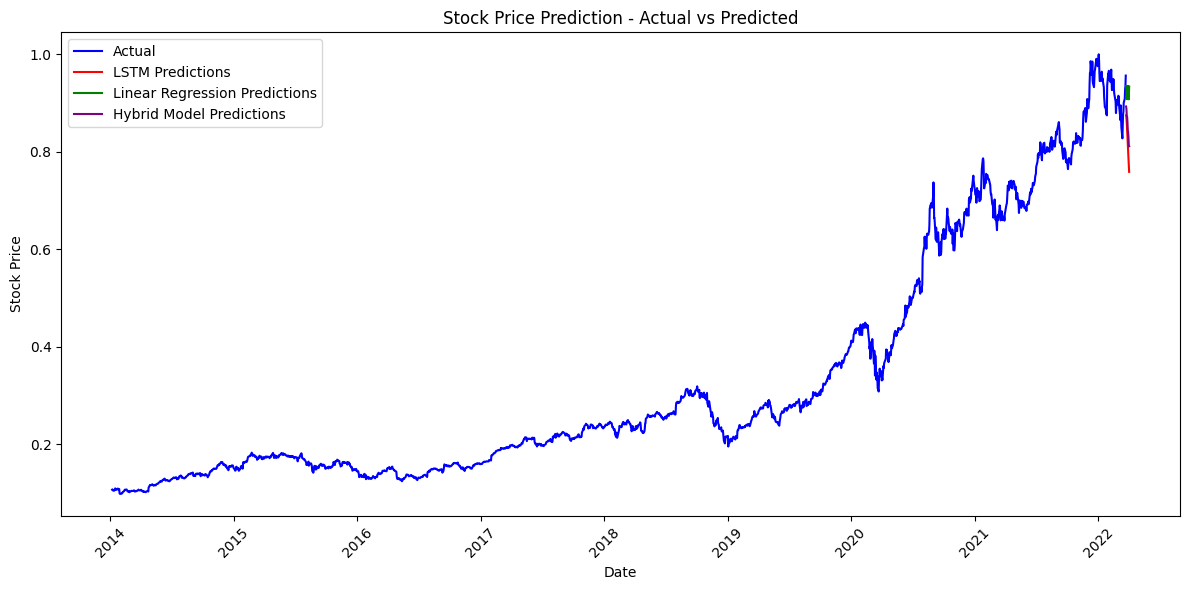

In [27]:
import matplotlib.pyplot as plt

# Assuming you have predictions_df from the previous code
# ... (previous code to generate predictions_df)

plt.figure(figsize=(12, 6))

# Plotting Actual vs Predicted for each model using predictions_df
plt.plot(data.index[-len(y_test):], y_test, label='Actual', color='blue') # Actual values
plt.plot(predictions_df['Date'], predictions_df['LSTM Predictions'], label='LSTM Predictions', color='red')
plt.plot(predictions_df['Date'], predictions_df['Linear Regression Predictions'], label='Linear Regression Predictions', color='green')
plt.plot(predictions_df['Date'], predictions_df['Hybrid Predictions'], label='Hybrid Model Predictions', color='purple')

plt.title('Stock Price Prediction - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()